## Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can take many forms, some can be advertisements for drinks and some are in the form of discounts or buy one get one free (BOGO). Not all users receive the same offer, therefore poses a challenge to solve with the data set. 

Another challenge presented by the data set is that the offers have time validity in which after certain amount of time left incomplete, the offers are expired. Another case that might raise a challenge in examining the effectiveness of these offers is that a particular customer can finish or claim the rewards yet never influenced by the offers to begin with. This can occur due to a customer receiving the offer never checks or views the offer. 

The data provides the different types of offers, user transactions and user demographic information. These data sets can be combined to analyze the customers behavior in depth.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## 1. Problem Statement

In this project, we will take a look at how we can leverage machine learning in developing classification for customers behavior. Specifically, through looking at their respective historical transactions and demographic information, we can predict if certain customers are worth sending offers to and which ones would fulfill the amount of spending Starbucks would prefer without sending these offers.

### 1.a. Project Overview

The project entails simulated data of Starbucks customers' behavior on the Starbucks rewards app. Starbucks customers sometimes receive an offer or two regarding Starbucks' products. Since this is only a simplified version of the actual data, this data set only contains an offer related to one product instead of many. The data set also notes that not all users receive the same offer, which means ultimately each user can receive a different combination of offers.

### 1.b. Problem Statement

This capstone challenge aims to build a successful machine learning model which could predict whether customers will most likely to complete an offer. The result of this project hopes to assist Starbucks decision in concentrating on which group of customers who are more likely to provide a positive reaction towards those offers. The customers' likeliness to participate and complete any sort of offer can depend on many things, such as (although not limited to):

1. Income level
2. Gender
3. Age
4. Platform of communication
5. Type of offer

It is noted that these are some of the variables which are expected to have a significant impact on the customers' behavior. The actual features which are deemed to be significant or substantial towards the completed offer will be explored further within the notebook.

### 1.c. Metrics

Since the final goal of this project is to build a machine learning model to predict the customers behavior, the problem can be simplified into a binary classification problem. Ultimately, the machine learning will predict:

**Whether a certain customer would more likely to complete an offer based on their profiles**

Due to the problem being a binary classification, we can simplify the metrics to an overall accuracy of the model. The other scoring computations will be included, e.g. *f1_score* and *precision*.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import re

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from init_setup import progress_bar

import warnings
warnings.filterwarnings('ignore')

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2. Analysis

The bulk of the data cleaning and exploration process will be performed in this part of the notebook. It is noted that while the visualization of the data presents in this section, the dataframes do not currently show the customers ids who have successfully completed the offer. A more thorough analysis regarding the relations between completed offer and other demographic features are shown in the next section.

### 2.a. Data Exploration and Visualization

In this section, the process of data cleaning and exploration for each dataset will be performed. The datasets portfolio, profile, and transcript are cleaned in order. Depending on the dataset's contents, data exploration is also carried out either before or after data cleaning. Each of the data cleaning process is captured within one function (therefore there are 3 different functions for the data cleaning process). 

As mentioned above, the data visualization in this section only concerns with the distribution of demographic features within the data set, such as age distribution based on gender, income, percentage of different event types of offers and so on.

#### 2.a.i. Dataset: *portfolio.json* 

The following process are performed in order to clean and explore the *portfolio.json* dataset:

1. Check the categorical data type columns to plan on how to clean them
2. Prior to cleaning the data, create a copy of the dataframe
3. Create dummies on the offer_type
4. Create dummies for the channels (different type of offer campaigns)
5. Concat these dummies values and drop the original columns

In [3]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [4]:
offer_types = portfolio['offer_type'].unique()
channels_combination = portfolio['channels'].values

print('Unique offer types:', offer_types)
print('\nChannels combination:')
for com in channels_combination:
    print(com)

Unique offer types: ['bogo' 'informational' 'discount']

Channels combination:
['email', 'mobile', 'social']
['web', 'email', 'mobile', 'social']
['web', 'email', 'mobile']
['web', 'email', 'mobile']
['web', 'email']
['web', 'email', 'mobile', 'social']
['web', 'email', 'mobile', 'social']
['email', 'mobile', 'social']
['web', 'email', 'mobile', 'social']
['web', 'email', 'mobile']


From the output above, it can be seen that the offer_types are consisted of 3 different types. The interesting aspect of this dataset is the values within the channels column. Since the values are contained within list, this is something that needs to be addressed when the data has to be cleaned.

A function to clean the dataset is provided below. Note that a new dataframe is created to preserve the original if it's ever needed in the future.

In [5]:
def portfolio_clean(df = portfolio):
    '''
    Clean portfolio dataframe

    Args:
        df (pandas.DataFrame): DataFrame of portfolio

    Returns:
        df (pandas.DataFrame): Cleaned DataFrame of portfolio
    '''
    df = df.copy()
    offer_dummies = pd.get_dummies(df['offer_type'], prefix = 'offer')
    channels = df['channels'].str.join(sep = '*').str.get_dummies(sep = '*').add_prefix('channel_')
    df = df.drop(['channels', 'offer_type'], axis = 1)
    df = df.rename(columns = {'id': 'offer_id', 
                              'reward': 'offer_reward', 
                              'difficulty': 'offer_difficulty', 
                              'duration': 'offer_duration'})
    columns_order = ['offer_id', 'offer_reward', 'offer_difficulty', 'offer_duration']
    df = df.reindex(columns = columns_order)
    df = pd.concat([df, offer_dummies, channels], axis = 1)
    df = df.reset_index(drop=True)
    return df

The portfolio data can now be cleaned. The following cell runs how the cleaned dataframe looks like.

In [6]:
df_portfolio = portfolio_clean()
df_portfolio.head(10)

offer_id  offer_reward  offer_difficulty  \
0  ae264e3637204a6fb9bb56bc8210ddfd            10                10   
1  4d5c57ea9a6940dd891ad53e9dbe8da0            10                10   
2  3f207df678b143eea3cee63160fa8bed             0                 0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9             5                 5   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7             5                20   
5  2298d6c36e964ae4a3e7e9706d1fb8c2             3                 7   
6  fafdcd668e3743c1bb461111dcafc2a4             2                10   
7  5a8bc65990b245e5a138643cd4eb9837             0                 0   
8  f19421c1d4aa40978ebb69ca19b0e20d             5                 5   
9  2906b810c7d4411798c6938adc9daaa5             2                10   

   offer_duration  offer_bogo  offer_discount  offer_informational  \
0               7           1               0                    0   
1               5           1               0                    0   
2               4           0               0                    1   
3               7           1               0                    0   
4              10           0               1                    0   
5               7           0               1                    0   
6              10           0               1                    0   
7               3           0               0                    1   
8               5           1               0                    0   
9               7           0               1                    0   

   channel_email  channel_mobile  channel_social  channel_web  
0              1               1               1            0  
1              1               1               1            1  
2              1               1               0            1  
3              1               1               0            1  
4              1               0               0            1  
5              1               1               1            1  
6              1               1               1            1  
7              1               1               1            0  
8              1               1               1            1  
9              1               1               0            1

#### 2.a.ii. Dataset: *profile.json* 

The following process are performed in order to clean and explore the *profile.json* dataset:

1. Check how many data entries are missing values
2. Check the customers' gender and income values for missing values
3. Create copy of dataframe and drop missing values (12.8% of the total data)
4. Create a datetime format for became_member_on column data
5. Find the total number of days a customer has been a member, assigned to days_membership column
6. Rename the column id to customer_id
7. The distribution plot of their income, age, and days of membership based on their genders are explored and visualized

In [7]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [8]:
profile.describe().T

count          mean           std         min         25%  \
age               17000.0  6.253141e+01     26.738580        18.0        45.0   
became_member_on  17000.0  2.016703e+07  11677.499961  20130729.0  20160526.0   
income            14825.0  6.540499e+04  21598.299410     30000.0     49000.0   

                         50%         75%         max  
age                     58.0        73.0       118.0  
became_member_on  20170802.0  20171230.0  20180726.0  
income               64000.0     80000.0    120000.0

In [9]:
profile.isnull().sum()*100/len(profile)

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [10]:
profile[(profile['gender'].isna()) & (profile['income'].isna())]

gender  age                                id  became_member_on  income
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6       None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7       None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
...      ...  ...                               ...               ...     ...
16980   None  118  5c686d09ca4d475a8f750f2ba07e0440          20160901     NaN
16982   None  118  d9ca82f550ac4ee58b6299cf1e5c824a          20160415     NaN
16989   None  118  ca45ee1883624304bac1e4c8a114f045          20180305     NaN
16991   None  118  a9a20fa8b5504360beb4e7c8712f8306          20160116     NaN
16994   None  118  c02b10e8752c4d8e9b73f918558531f7          20151211     NaN

[2175 rows x 5 columns]

It is interesting to see how for every gender unknown, the income is also unknown. Also notice that the age is set to 118 for all the rows with NaN values. Due to the ratio of these missing values amount to roughly 12.8%, let's drop these rows.

The following function cleans the profile dataframe. This process includes dropping the NaN values and converting the became_member_on to datetime format. In addition, it might be in our best interest to check when the customers start becoming a member. This can be illustrated better by creating membership days column.

In [11]:
def profile_clean(df = profile):
    '''
    Clean profile dataframe

    Args:
        df (pandas.DataFrame): DataFrame of profile

    Returns:
        df (pandas.DataFrame): Cleaned DataFrame of profile
    '''
    df = df.copy()
    df = df.dropna()
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format = '%Y%m%d')
    df['days_membership'] = (datetime.datetime.today().date() - df['became_member_on'].dt.date).dt.days
    df = df.rename(columns = {'id': 'customer_id'})
    columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on', 'days_membership']
    df = df.reindex(columns = columns_order)
    df = df.reset_index(drop=True)
    return df

In [12]:
df_profile = profile_clean()
df_profile.head()

customer_id gender  age    income became_member_on  \
0  0610b486422d4921ae7d2bf64640c50b      F   55  112000.0       2017-07-15   
1  78afa995795e4d85b5d9ceeca43f5fef      F   75  100000.0       2017-05-09   
2  e2127556f4f64592b11af22de27a7932      M   68   70000.0       2018-04-26   
3  389bc3fa690240e798340f5a15918d5c      M   65   53000.0       2018-02-09   
4  2eeac8d8feae4a8cad5a6af0499a211d      M   58   51000.0       2017-11-11   

   days_membership  
0             1436  
1             1503  
2             1151  
3             1227  
4             1317

Several distribution plots can be presented to give an idea regarding the customers' demographic.

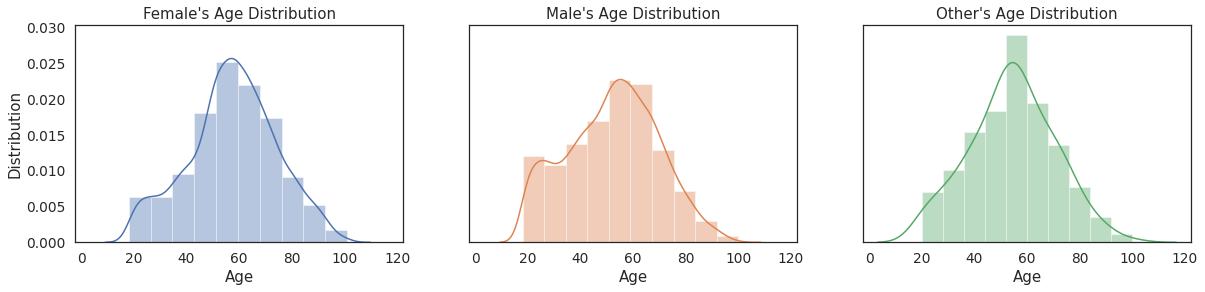

In [13]:
sns.set(style = 'white', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(df_profile[df_profile['gender'] == 'F']['age'], bins = 10, color = palette[0]);
plt.title('Female\'s Age Distribution')
plt.xlabel('Age')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(df_profile[df_profile['gender'] == 'M']['age'], bins = 10, color = palette[1]);
plt.title('Male\'s Age Distribution')
plt.xlabel('Age')

plt.sca(ax[2])
sns.distplot(df_profile[df_profile['gender'] == 'O']['age'], bins = 10, color = palette[2]);
plt.title('Other\'s Age Distribution')
plt.xlabel('Age')
plt.show()

fig.savefig('figures/profile_age.svg', dpi = 300)

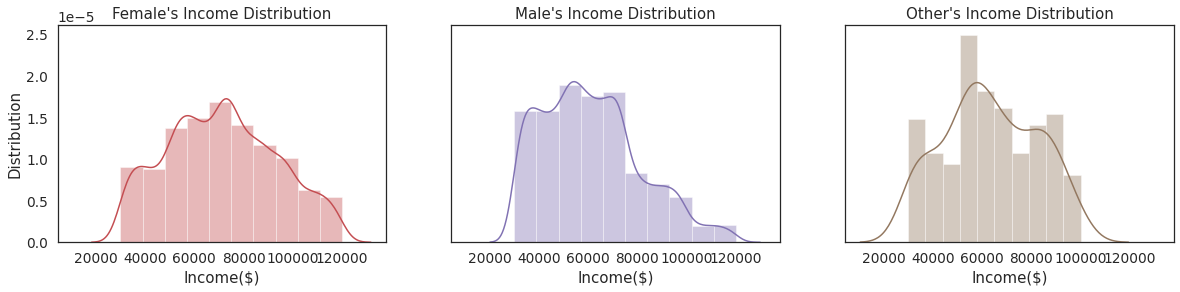

In [14]:
sns.set(style = 'white', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(df_profile[df_profile['gender'] == 'F']['income'], bins = 10, color = palette[3]);
plt.title('Female\'s Income Distribution')
plt.xlabel('Income($)')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(df_profile[df_profile['gender'] == 'M']['income'], bins = 10, color = palette[4]);
plt.title('Male\'s Income Distribution')
plt.xlabel('Income($)')

plt.sca(ax[2])
sns.distplot(df_profile[df_profile['gender'] == 'O']['income'], bins = 10, color = palette[5]);
plt.title('Other\'s Income Distribution')
plt.xlabel('Income($)')
plt.show()

fig.savefig('figures/profile_income.svg', dpi = 300)

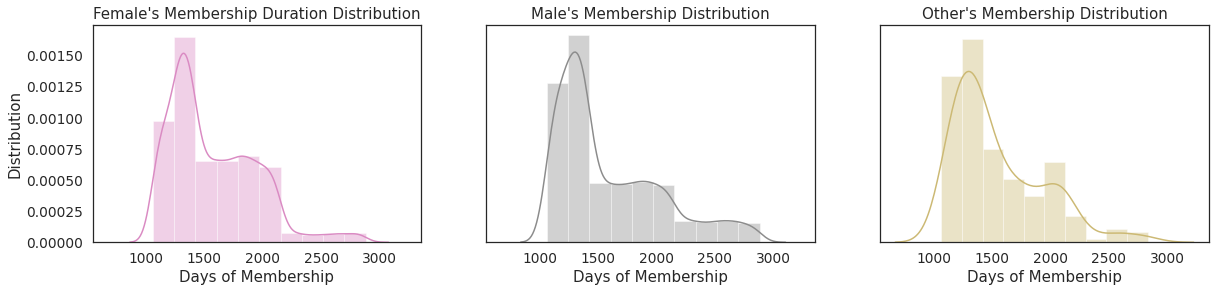

In [15]:
sns.set(style = 'white', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(df_profile[df_profile['gender'] == 'F']['days_membership'], bins = 10, color = palette[6]);
plt.title('Female\'s Membership Duration Distribution')
plt.xlabel('Days of Membership')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(df_profile[df_profile['gender'] == 'M']['days_membership'], bins = 10, color = palette[7]);
plt.title('Male\'s Membership Distribution')
plt.xlabel('Days of Membership')

plt.sca(ax[2])
sns.distplot(df_profile[df_profile['gender'] == 'O']['days_membership'], bins = 10, color = palette[8]);
plt.title('Other\'s Membership Distribution')
plt.xlabel('Days of Membership')
plt.show()

fig.savefig('figures/profile_membership.svg', dpi = 300)

#### 2.c.iii. Dataset: *transcript.json* 

The following process are performed in order to clean and explore the *transcript.json* dataset:

1. Check the unique event types
2. Check the percentage of each types (useful to see how many completed the offer)
3. Plot the percentage of these unique event types
4. Create a copy of the dataframe prior to cleaning
5. Finding the customer_id data to keep (the one intersecting or contained in the *profile.json*)
6. Change the time format from hours to days
7. Create two dataframes:
    - One containing offer ids
    - One containing transaction amount
8. Rename the person column to customer_id to keep it consistent with the df_profile dataframe

In [16]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [17]:
transcript['event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

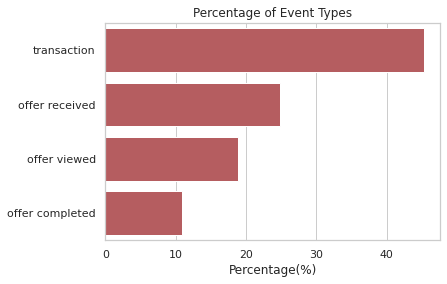

In [18]:
percentage = transcript['event'].value_counts()*100/len(transcript)
val_trans = percentage.values.tolist()
event_type = percentage.index.tolist()
sns.set(style = 'whitegrid', font_scale = 1.0)
sns.barplot(x = val_trans, y = event_type, color = 'r')
plt.title('Percentage of Event Types')
plt.xlabel('Percentage(%)')

plt.savefig('figures/event_types.svg', dpi = 300)
plt.show()

In [19]:
def transcript_clean(df = transcript, profile = df_profile):
    '''
    Clean transcript dataframe

    Args:
        df (pandas.DataFrame): DataFrame of transcript

    Returns:
        df_o (pandas.DataFrame): Cleaned DataFrame containing offers
        df_t (pandas.DataFrame): Cleaned DataFrame containing transactions
    '''
    df = df.copy()
    data_to_keep = df['person'].isin(profile['customer_id'])
    df = df[data_to_keep]
    df['time'] = df['time']/24
    
    filter_row = df['event'] == 'transaction'
    non_offer_df = df[filter_row]
    df_t = pd.DataFrame(data = non_offer_df)
    df_t = df_t.drop(['value', 'event'], axis = 1)
    df_t['amount'] = non_offer_df['value'].apply(lambda x: list(x.values())[0])
    df_t = df_t.rename(columns = {'person': 'customer_id'})
    df_t = df_t.reset_index(drop=True)
    
    filter_row = df['event'] != 'transaction'
    offer_df = df[filter_row]
    df_o = pd.DataFrame(data = offer_df)
    dummies = pd.get_dummies(df_o['event'])
    df_o = df_o.drop(['event', 'value'], axis = 1)
    df_o['offer_id'] = offer_df['value'].apply(lambda x: list(x.values())[0])
    df_o = df_o.rename(columns = {'person': 'customer_id'})
    df_o = pd.concat([df_o, dummies], axis = 1)
    columns_order = ['customer_id', 'offer_id', 'time', 'offer completed', 'offer received', 'offer viewed']
    df_o = df_o.reindex(columns = columns_order)
    df_o = df_o.reset_index(drop=True)
    
    return df_o, df_t

In [20]:
df_offer, df_transaction = transcript_clean()

In [21]:
df_transaction.head()

customer_id  time  amount
0  02c083884c7d45b39cc68e1314fec56c   0.0    0.83
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f   0.0   34.56
2  54890f68699049c2a04d415abc25e717   0.0   13.23
3  b2f1cd155b864803ad8334cdf13c4bd2   0.0   19.51
4  fe97aa22dd3e48c8b143116a8403dd52   0.0   18.97

In [22]:
df_offer.head()

customer_id                          offer_id  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   0.0   
1  e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5   0.0   
2  389bc3fa690240e798340f5a15918d5c  f19421c1d4aa40978ebb69ca19b0e20d   0.0   
3  2eeac8d8feae4a8cad5a6af0499a211d  3f207df678b143eea3cee63160fa8bed   0.0   
4  aa4862eba776480b8bb9c68455b8c2e1  0b1e1539f2cc45b7b9fa7c272da2e1d7   0.0   

   offer completed  offer received  offer viewed  
0                0               1             0  
1                0               1             0  
2                0               1             0  
3                0               1             0  
4                0               1             0

### 2.b. Conclusion

From these separate datasets, it can be concluded that some of the information are related through features such as customer_id. Therefore, it is beneficial to combined the datasets containing desired features into one. This is going to be performed in the next section, Feature Selection and Engineering, which aims to provide enough significant features so that our machine learning model can predict whether a customer is more likely to finish the offer or not.

## 3. Feature Selection and Engineering

Although the 3 datasets above were successfully cleaned, in order to process these data into a machine learning model, the datasets have to be combined. Features which are deemed significant will be included in constructing the new dataframe as well as any other features to be created (engineered). 

### 3.a. Define pandas.DataFrame 

The following procedure is performed in obtaining a clean dataframe complete with its features:

1. Index through unique customer_id
2. For each unique customer_id, find the offer received for that customer_id
3. Within the time window given by each offer, determine:
    - Amount of money customer spent
    - Whether the offer is completed 
    - Other demographic information regarding this customer
    - Add the offer information

In [23]:
print(df_portfolio.columns.tolist())
print(df_profile.columns.tolist())
print(df_transaction.columns.tolist())
print(df_offer.columns.tolist())

['offer_id', 'offer_reward', 'offer_difficulty', 'offer_duration', 'offer_bogo', 'offer_discount', 'offer_informational', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web']
['customer_id', 'gender', 'age', 'income', 'became_member_on', 'days_membership']
['customer_id', 'time', 'amount']
['customer_id', 'offer_id', 'time', 'offer completed', 'offer received', 'offer viewed']


In [24]:
def clean_data(df_portfolio, df_profile, df_offer, df_transaction):
    '''
    Combine df_portfolio, df_profile, df_offer, and
    df_transaction

    Args:
        df_portfolio (pandas.DataFrame): Clean DataFrame of portfolio
        df_profile (pandas.DataFrame): Clean DataFrame of profile
        df_offer (pandas.DataFrame): Clean DataFrame of offer
        df_transaction (pandas.DataFrame): Clean DataFrame of transaction
    Returns:
        clean_data (pandas.DataFrame): DataFrame containing information from
                                       all of the data input in the desired 
                                       format
    '''
    clean_data = []
    customer_list = df_profile['customer_id'].unique().tolist()
    progress_bar(0, len(customer_list), prefix='Progress:', suffix='Complete', length=30)
    iter_ = 0
    for customer_id in customer_list:
        index_customer = df_profile[df_profile['customer_id'] == customer_id]
        offer_filtered = df_offer[df_offer['customer_id'] == customer_id]
        transaction_id = df_transaction[df_transaction['customer_id'] == customer_id]
        
        offer_complete = offer_filtered[offer_filtered['offer completed'] == 1]
        offer_view = offer_filtered[offer_filtered['offer viewed'] == 1]
        offer_receive = offer_filtered[offer_filtered['offer received'] == 1]
        
        # Loop through customers who obtained offers
        for index in range(len(offer_receive)):
            offer_id = offer_receive.iloc[index]['offer_id']
            offer_info = df_portfolio[df_portfolio['offer_id'] == offer_id]
            duration = offer_info['offer_duration'].values[0]
            portfolio = offer_info[['offer_duration', 
                                    'offer_reward', 
                                    'offer_difficulty', 
                                    'offer_bogo', 
                                    'offer_discount', 
                                    'offer_informational',
                                    'channel_email', 
                                    'channel_mobile', 
                                    'channel_social', 
                                    'channel_web']].values[0]

            customer = index_customer[['gender', 
                                       'age', 
                                       'income', 
                                       'days_membership', 
                                       'became_member_on']].values[0]

            offer_start = offer_receive.iloc[index]['time']
            offer_end = offer_start + duration

            # np.logical_and is used instead of and to avoid ambiguous truth value
            transaction_filter = np.logical_and(transaction_id['time'] >= offer_start, 
                                                transaction_id['time'] <= offer_end)
            completed_filter =  np.logical_and(offer_complete['time'] >= offer_start, 
                                               offer_complete['time'] <= offer_end)
            viewed_filter = np.logical_and(offer_view['time'] >= offer_start, 
                                           offer_view['time'] <= offer_end)

            offer_finished = (completed_filter.sum() > 0) and (viewed_filter.sum() > 0)
            period_transaction = transaction_id[transaction_filter]['amount'].sum() 

            data_entry_1 = [offer_id, customer_id, int(offer_finished), period_transaction]
            data_entry_2 = list(portfolio)
            data_entry_3 = list(customer)

            data = data_entry_1 + data_entry_2 + data_entry_3

            clean_data.append(data)
        iter_ += 1
        progress_bar(iter_, len(customer_list), prefix='Progress:', suffix='Complete', length=30)

    column_names = [
        'offer_id', 
        'customer_id', 
        'offer_completed', 
        'money_spent', 
        'offer_duration', 
        'offer_reward', 
        'offer_difficulty', 
        'offer_bogo',          
        'offer_discount', 
        'offer_informational', 
        'channel_email', 
        'channel_mobile',  
        'channel_social', 
        'channel_web',                                             
        'gender', 
        'age', 
        'income', 
        'days_membership', 
        'became_member_on'
    ]

    clean_data = pd.DataFrame(data = clean_data, columns = column_names)
    # Grab the joining year
    clean_data['became_member_on'] = clean_data['became_member_on'].dt.year
    
    return clean_data

In [25]:
processed_data = clean_data(df_portfolio, df_profile, df_offer, df_transaction)

Progress: |==============================| 100.0% Complete


In [26]:
processed_data.to_csv('data/processed_data.csv', index = False)

In [27]:
processed_data = pd.read_csv('data/processed_data.csv')
processed_data.head()

offer_id                       customer_id  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  0610b486422d4921ae7d2bf64640c50b   
1  3f207df678b143eea3cee63160fa8bed  0610b486422d4921ae7d2bf64640c50b   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef   
3  5a8bc65990b245e5a138643cd4eb9837  78afa995795e4d85b5d9ceeca43f5fef   
4  ae264e3637204a6fb9bb56bc8210ddfd  78afa995795e4d85b5d9ceeca43f5fef   

   offer_completed  money_spent  offer_duration  offer_reward  \
0                0        23.22               7             5   
1                0        23.22               4             0   
2                1        37.67               7             5   
3                0        49.39               3             0   
4                1        48.28               7            10   

   offer_difficulty  offer_bogo  offer_discount  offer_informational  \
0                 5           1               0                    0   
1                 0           0               0                    1   
2                 5           1               0                    0   
3                 0           0               0                    1   
4                10           1               0                    0   

   channel_email  channel_mobile  channel_social  channel_web gender  age  \
0              1               1               0            1      F   55   
1              1               1               0            1      F   55   
2              1               1               0            1      F   75   
3              1               1               1            0      F   75   
4              1               1               1            0      F   75   

     income  days_membership  became_member_on  
0  112000.0             1436              2017  
1  112000.0             1436              2017  
2  100000.0             1503              2017  
3  100000.0             1503              2017  
4  100000.0             1503              2017

In [28]:
filter_data = processed_data[(processed_data['offer_completed'] == 1) & (processed_data['gender'] != 'O')]

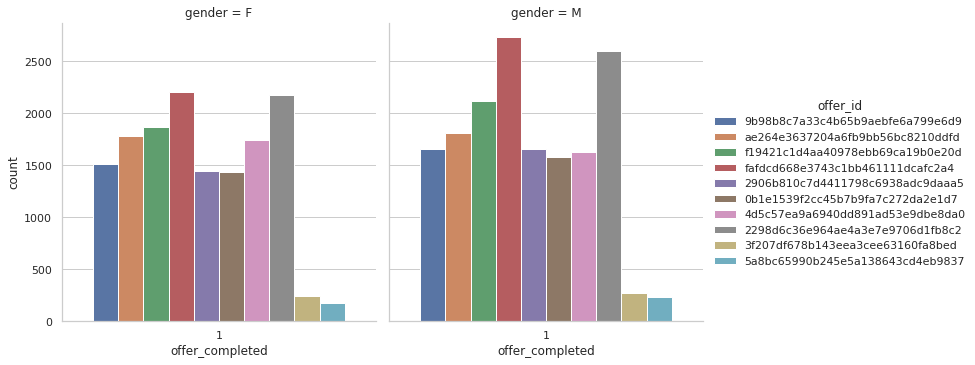

In [29]:
sns_plot = sns.catplot(data = filter_data, x = 'offer_completed', 
                       hue = 'offer_id', kind = 'count', col = 'gender');
plt.savefig('figures/offer_id_gender_dist.svg', dpi = 300);

The plot above presents the number of completed offers by customers filtered by gender. It is seen that more male customers as overall complete the offers, compared to females. But this is not necessarily mean that males are more likely to complete offers in comparison to females, but rather due to the number of males in the data set is larger than the females.

One thing to note however, the offer_id labeled in red seems to be the more popular completed offer than the rest. One thing that Starbucks can learn from this count plot is that the last two offer types are most likely do not cater to what the customers want, since they only represent a very small portion of the entire completed offer counts. 

In [30]:
male = len(processed_data[processed_data['gender'] == 'M'])
female = len(processed_data[processed_data['gender'] == 'F'])

male, female

(38129, 27456)

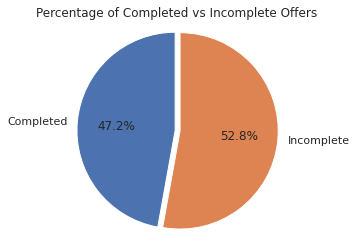

In [31]:
ones = len(processed_data[processed_data['offer_completed'] == 1])
zeros = len(processed_data) - ones

labels = ['Completed', 'Incomplete']
sizes = [ones, zeros]
explode = (0, 0.05)
pie_plot = plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%',
                   shadow=False, startangle=90)
plt.title('Percentage of Completed vs Incomplete Offers')
plt.axis('equal')
plt.show()

This pie chart provides an idea of how balanced the data set is. This means that our target value (offer_completed) which is going to be used for our machine learning will not have significant negative impact on how the model will perform. 

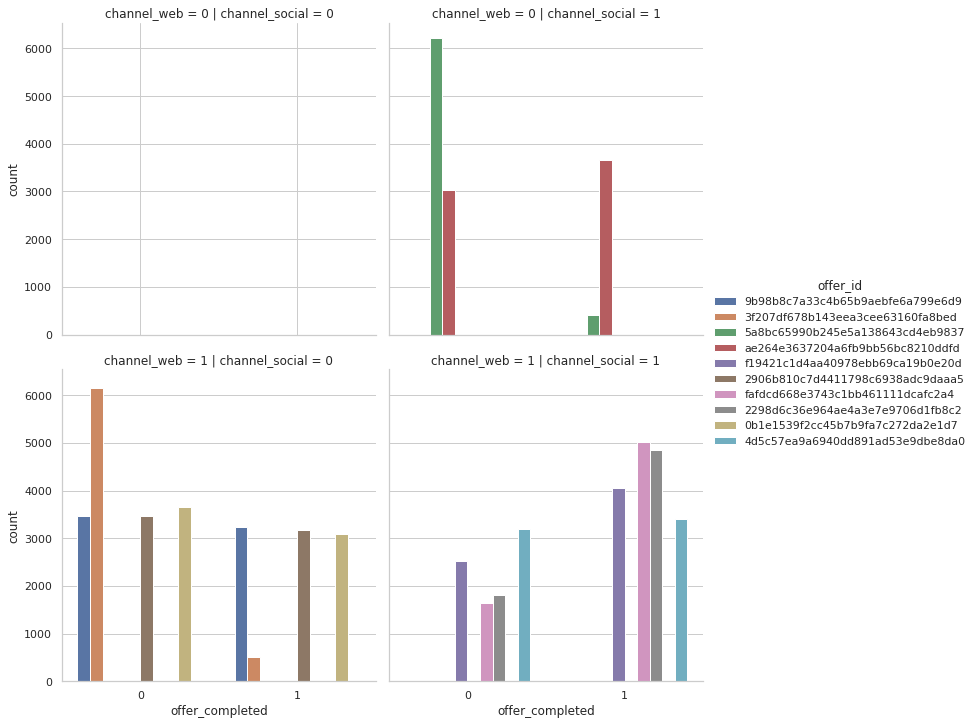

In [32]:
sns_plot = sns.catplot(data = processed_data, x = 'offer_completed', 
                       hue = 'offer_id', kind = 'count', col = 'channel_social',
                       row = 'channel_web');
plt.savefig('figures/channel_dist.svg', dpi = 300);

Another interesting aspect to see about the customer behavior of Starbucks is how these offers are sent or distributed to them. The plot above describes how well using either web or social as the channel for advertising or promoting the offers can do in convincing the customers to complete the offer. 

Distributing the offer through only one of these two channels are most likely to result in majority of the customers to not complete the offer. If this method still provides a benefit (profitable margin) for Starbucks, then it is still proven to be an effective method. However, Starbucks can pivot their choice of channel into **both web and social** in order to maximize the number of people completing their offers. One reason could be that once a person is exposed to multiple channels showing Starbucks' offers, he or she will be more convinced to complete said offers (this is including email as a channel, as most of these offers are distributed using emails in the first place.

### 3.b. Conclusion

The DataFrame ends up having 19 columns. Out of all these 19 columns, most likely several of these variables will be used for the machine learning model. It is also important to check whether these features can be improved even futher through preprocessing. Not all of these features can have high correlation values with our target column: 'offer_completed'. Therefore it only makes sense to choose features that are significant enough for the machine learning model to make predictions. The next section will explore and discuss about machine learning models. 

## 4. Machine Learning Model Selection and Tuning

This section mainly concerns with how to choose the best machine learning model for this particular problem. The main approach in this section is as follows:

1. Data preprocessing
2. Model selection (through exploration of five options)
3. Learning curve analysis
4. Features importance

From these 4 steps, it is expected that the project can achieve a quite high percentage of accuracy score while maintaining minimum number of features, therefore reducing training time. 

In [33]:
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import plot_confusion_matrix

import xgboost
from xgboost import XGBClassifier

### 4.a. Data Preprocessing

Continuing to prepare the data from the previous section:

1. Once the DataFrame is defined:
    - Create dummies for gender and age
    - Normalize the following features:
        - 'money_spent' 
        - 'offer_duration'
        - 'offer_reward'
        - 'offer_difficulty'
        - 'income'
        - 'days_membership'

The following procedure is performed to complete the appropriate data preprocessing:

1. Shuffle the data (randomize entries)
2. Determine from the data correlation if there is anything out of the ordinary:
    - Remove channel_email due to little to no variability 
3. Create a heatmap to analyze the signifcant correlations
4. Include the following features for machine learning model:
    - 'money_spent'
    - 'offer_duration'
    - 'offer_reward'
    - 'offer_difficulty', 
    - 'offer_discount'
    - 'offer_informational'
    - 'channel_social'
    - 'channel_web',
    - 'days_membership'
    - '2016'
    - '2018'

In [34]:
data = pd.read_csv('data/processed_data.csv')
data.head()

offer_id                       customer_id  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  0610b486422d4921ae7d2bf64640c50b   
1  3f207df678b143eea3cee63160fa8bed  0610b486422d4921ae7d2bf64640c50b   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef   
3  5a8bc65990b245e5a138643cd4eb9837  78afa995795e4d85b5d9ceeca43f5fef   
4  ae264e3637204a6fb9bb56bc8210ddfd  78afa995795e4d85b5d9ceeca43f5fef   

   offer_completed  money_spent  offer_duration  offer_reward  \
0                0        23.22               7             5   
1                0        23.22               4             0   
2                1        37.67               7             5   
3                0        49.39               3             0   
4                1        48.28               7            10   

   offer_difficulty  offer_bogo  offer_discount  offer_informational  \
0                 5           1               0                    0   
1                 0           0               0                    1   
2                 5           1               0                    0   
3                 0           0               0                    1   
4                10           1               0                    0   

   channel_email  channel_mobile  channel_social  channel_web gender  age  \
0              1               1               0            1      F   55   
1              1               1               0            1      F   55   
2              1               1               0            1      F   75   
3              1               1               1            0      F   75   
4              1               1               1            0      F   75   

     income  days_membership  became_member_on  
0  112000.0             1436              2017  
1  112000.0             1436              2017  
2  100000.0             1503              2017  
3  100000.0             1503              2017  
4  100000.0             1503              2017

In [35]:
# Create dummies for gender, age, year
gender_dummies = pd.get_dummies(data['gender'], prefix = 'gender')
year_dummies = pd.get_dummies(data['became_member_on']).astype(int)

# For age use function process_cut
cut_points = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
data['age_cat'] = pd.cut(data['age'], cut_points)
age_dummies = pd.get_dummies(data['age_cat'])

data = pd.concat([data, gender_dummies, age_dummies, year_dummies], axis = 1)
data = data.drop(['age', 'age_cat', 'gender', 'became_member_on'], axis = 1)

column_normalize = ['money_spent', 'offer_duration', 'offer_reward', 
                    'offer_difficulty', 'income', 'days_membership']

for col in column_normalize:
    data[col] = minmax_scale(data[col])
    
data.columns = data.columns.astype(str)

In [36]:
data = shuffle(data)

In [37]:
data.corr()

offer_completed  money_spent  offer_duration  \
offer_completed             1.000000     0.376093        0.294742   
money_spent                 0.376093     1.000000        0.160693   
offer_duration              0.294742     0.160693        1.000000   
offer_reward                0.191328     0.042710        0.161964   
offer_difficulty            0.229377     0.116729        0.809257   
offer_bogo                  0.112317    -0.012380       -0.184856   
offer_discount              0.216109     0.120023        0.741376   
offer_informational        -0.402291    -0.131900       -0.682049   
channel_email                    NaN          NaN             NaN   
channel_mobile              0.009421    -0.035799       -0.531442   
channel_social              0.160234     0.039172       -0.185837   
channel_web                 0.166774     0.048939        0.340997   
income                      0.143236     0.181374       -0.002406   
days_membership             0.160748     0.108234        0.001714   
gender_F                    0.099939     0.092032       -0.004266   
gender_M                   -0.104175    -0.092969        0.004135   
gender_O                    0.019893     0.005747        0.000472   
(10, 20]                   -0.037888    -0.028458       -0.011200   
(20, 30]                   -0.059013    -0.039838        0.003482   
(30, 40]                   -0.021888    -0.023181        0.008308   
(40, 50]                    0.006189    -0.015485       -0.004141   
(50, 60]                    0.026691     0.023935        0.001797   
(60, 70]                    0.018830     0.022802        0.002234   
(70, 80]                    0.013550     0.015732        0.000620   
(80, 90]                    0.015740     0.016272       -0.007861   
(90, 100]                   0.004928     0.006085       -0.005127   
2013                       -0.000278    -0.020997        0.001101   
2014                       -0.000322    -0.036293        0.001122   
2015                        0.074851     0.066822        0.005546   
2016                        0.157655     0.138450        0.000824   
2017                       -0.014547    -0.000225       -0.013855   
2018                       -0.183988    -0.152752        0.009925   

                     offer_reward  offer_difficulty  offer_bogo  \
offer_completed          0.191328          0.229377    0.112317   
money_spent              0.042710          0.116729   -0.012380   
offer_duration           0.161964          0.809257   -0.184856   
offer_reward             1.000000          0.465176    0.791978   
offer_difficulty         0.465176          1.000000   -0.031252   
offer_bogo               0.791978         -0.031252    1.000000   
offer_discount          -0.287104          0.598690   -0.666670   
offer_informational     -0.617818         -0.695277   -0.407434   
channel_email                 NaN               NaN         NaN   
channel_mobile          -0.079089         -0.742892    0.273344   
channel_social           0.286961         -0.156460    0.248637   
channel_web             -0.120241          0.243572   -0.104735   
income                   0.001971         -0.000858    0.001996   
days_membership          0.003557          0.001820    0.003498   
gender_F                 0.000306         -0.001124    0.001171   
gender_M                 0.000841          0.001597   -0.000450   
gender_O                -0.004865         -0.002028   -0.003037   
(10, 20]                 0.004018         -0.006846    0.007268   
(20, 30]                 0.000675          0.004971   -0.002761   
(30, 40]                -0.002178          0.003066   -0.004045   
(40, 50]                 0.005366         -0.001885    0.005760   
(50, 60]                -0.002892          0.003423   -0.002532   
(60, 70]                 0.001715         -0.000215    0.000437   
(70, 80]                -0.000788          0.000413    0.001783   
(80, 90]                -0.006275         -0.009136   -0.005112   
(

In [38]:
data = data.drop(['channel_email'], axis = 1)

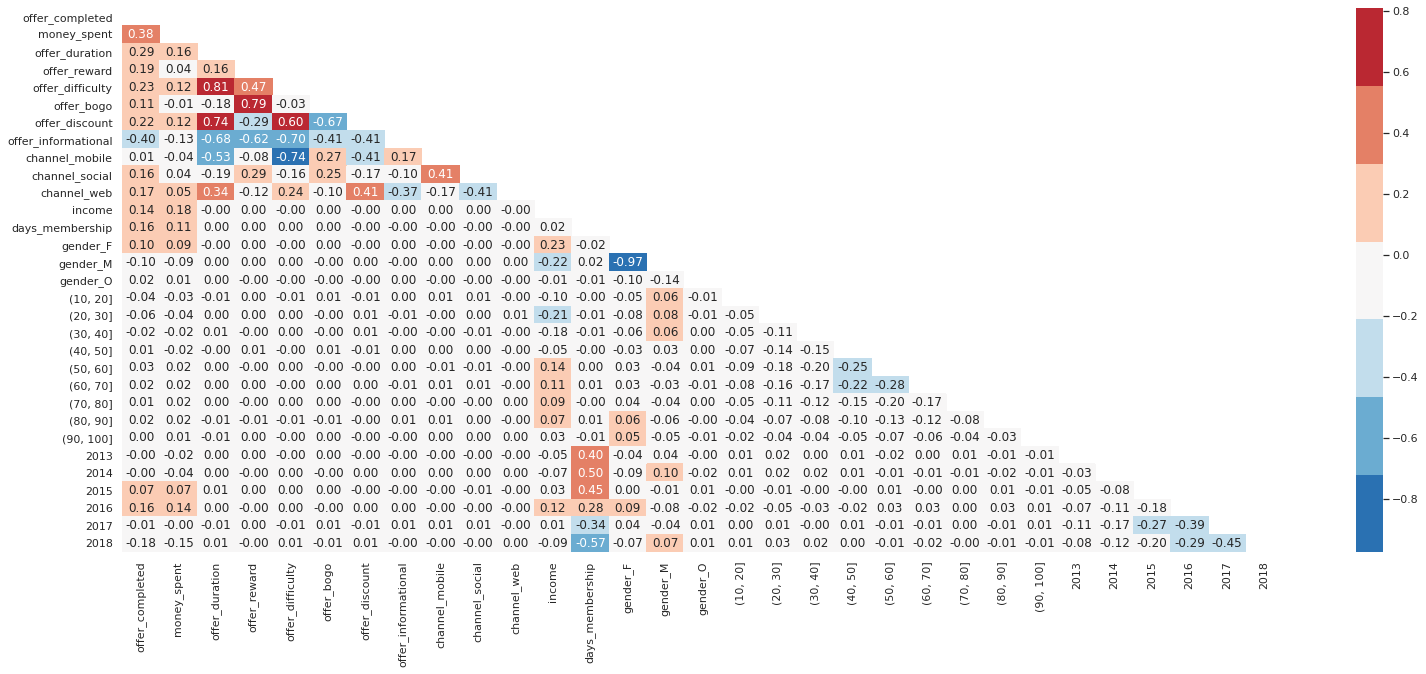

In [39]:
heatmap_vars = data

corr = heatmap_vars.corr()
mask = np.triu(corr)
cmap = sns.color_palette("RdBu_r", 7)

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize = (26, 10))
    ax = sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, fmt = '.2f')

figure = ax.get_figure()    
figure.savefig('figures/heatmap_features.svg', dpi = 300)

In [40]:
X = data[['money_spent', 'offer_duration', 'offer_reward', 'offer_difficulty', 
              'offer_discount', 'offer_informational', 'channel_social', 'channel_web',
              'days_membership', '2016', '2018']]
y = data['offer_completed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 4.b. Model Exploration

There are 5 machine learning models for classification that will be examined thoroughly. These are:

1. Logistic Regression
2. Decision Tree
3. Adaptive Boosting
4. Random Forest
5. XGB Classifier

For each of the model, the cross validation technique of 10-fold is used to calculate the accuracy of each model. These values are going to be shown in a DataFrame model_df. The dataframe is sorted based on the model test accuracy (the highest at the top).

In [41]:
model_opt = [LogisticRegression(),
             DecisionTreeClassifier(),
             AdaBoostClassifier(),
             RandomForestClassifier(),
             XGBClassifier(eval_metric='logloss')] 

model_cols = ['Model Name', 'Model Parameters', 'Model Test Accuracy']
model_df = pd.DataFrame(columns = model_cols)

counter = 0
for model in model_opt:
    
    model_name = model.__class__.__name__
    model_df.loc[counter, 'Model Name'] = model_name
    model_df.loc[counter, 'Model Parameters'] = str(model.get_params())
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 10)
    
    model_df.loc[counter, 'Model Test Accuracy'] = np.mean(accuracy)
    
    counter += 1
    
model_df.sort_values(by = ['Model Test Accuracy'], ascending = False, inplace = True)

In [42]:
model_df.head()

Model Name                                   Model Parameters  \
4           XGBClassifier  {'objective': 'binary:logistic', 'use_label_en...   
2      AdaBoostClassifier  {'algorithm': 'SAMME.R', 'base_estimator': Non...   
3  RandomForestClassifier  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
1  DecisionTreeClassifier  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   
0      LogisticRegression  {'C': 1.0, 'class_weight': None, 'dual': False...   

  Model Test Accuracy  
4            0.912632  
2            0.902801  
3            0.901165  
1            0.868722  
0            0.858365

The XGB Classifier comes out on top. The top 3 performed models will be analyzed further using Learning Curve. 

### 4.c. Learning Curve

It is necessary to analyze how the machine learning models perform as overall. One tool that can help us analyze this is the learning curve.
The learning curve provides an overall look of how the model performs and how it will generalize to data that it has not seen before.

From this analysis, it can be seen that XGB Classifier is the superior model compared to the Random Forest and Adaptive Boosting. This is mainly due to its validation and training score converges to a similar value over time. Unlike the other two which suffer from high bias and high variance.

In [43]:
def plot_learning_curve(model_str, train_sizes, train_scores, validation_scores):
    '''
    Plotting the learning curve of a machine learning model given the input
    parameters

    Params:
        model_str (str): model's name
        train_sizes (list): list of training sizes to be calculated
        train_scores (list): training scores of model (metrics)
        validation_scores (list): validation scores of model (metrics)
    Returns:
        None
        *this function plots learning curves with their std bounds
    '''
    figure, ax = plt.subplots(figsize = (8, 6))
    
    train_scores_mean = train_scores.mean(axis = 1)
    train_scores_std = train_scores.std(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    validation_scores_std = validation_scores.std(axis = 1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training Score', marker = 'o', color = 'r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color = "r")
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Score', marker = 'o', color = 'g')
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                         validation_scores_mean + validation_scores_std, alpha=0.1,
                         color = "g")
    
    plt.ylabel('Accuracy')
    plt.xlabel('Training set size')
    plt.title('Learning curves for ' + str(model_str))
    plt.legend()
    plt.show()
    
    figure = ax.get_figure()  
    figure.savefig('figures/learning_curve_' + str(model_str).lower() + '.svg', dpi = 300)

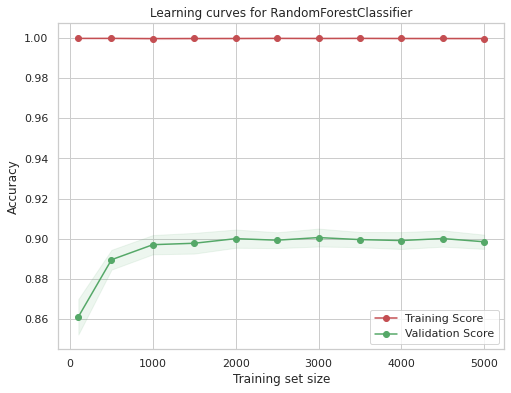

In [44]:
train_sizes = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

model = RandomForestClassifier()
                   
model.fit(X_train, y_train)
                   
train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = X_train, y = y_train, 
                                                              train_sizes = train_sizes, cv = 10)
plot_learning_curve('RandomForestClassifier', train_sizes, train_scores, validation_scores)

The Random Forest model suffers from high variance. As the training size is increased, the model is not capable of improving any further. This can be fixed by using less features. However the data preprocessing step already reduced a good number of interesting features to include within the model. Another approach is to add more data, yet the number of data in the scope of this project is fixed.

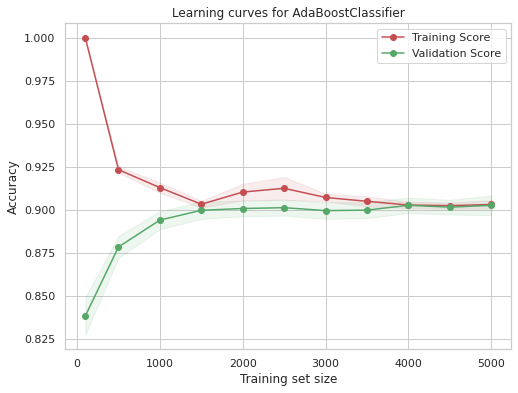

In [45]:
model = AdaBoostClassifier()                
model.fit(X_train, y_train)
                   
train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = X_train, y = y_train, 
                                                              train_sizes = train_sizes, cv = 10)
plot_learning_curve('AdaBoostClassifier', train_sizes, train_scores, validation_scores)

The Adaptive Boosting model suffers from high bias. This can be seen from the both training and validation score stays too close together. This will more likely result in poor fit and especially poor generalization of the data (towards the data it hasn't seen before).

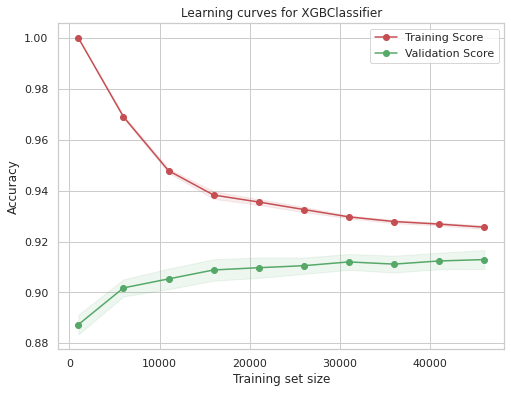

In [46]:
train_sizes = list(range(1000, 47000, 5000))
model = XGBClassifier(eval_metric='logloss')
                   
fit = model.fit(X_train, y_train)
                   
train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = X_train, y = y_train, 
                                                              train_sizes = train_sizes, cv = 10)
plot_learning_curve('XGBClassifier', train_sizes, train_scores, validation_scores)

This is ideally the desired learning curve of a machine learning model. The validation score of XGB Classifier converges to a similar value of that the training score. This model is more likely to generalize better in comparison to the other models examined previously.

### 4.d. Model Tuning GridSearchCV

Several of the parameters of the XGB Classifier can also be tuned. Since optimizing the parameters over a large numbers of variation can result in long runtime, only a few of these parameters are going to be tuned. The max depth is chosen to be tuned since it can cause overfitting. The parallel tree is computed for boosting the algorithm. The booster is the type of booster that can assist the model the most.

In [47]:
model = XGBClassifier(eval_metric='logloss')

hyperparameters = {
                    'max_depth': [6], # 'max_depth': [3, 5, 6]
                    'booster': ['gbtree'], # 'booster': ['gbtree', 'gblinear']
                    'num_parallel_tree': [1] # 'num_parallel_tree': [1, 2]
}

grid = GridSearchCV(model, param_grid = hyperparameters, cv = 10, 
                    scoring =  ['accuracy', 'precision', 'f1'], refit = 'accuracy')
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_score = grid.best_score_
tuned_model = grid.best_estimator_

In [48]:
print('Best parameters of XGB Classifier:', str(best_params))

Best parameters of XGB Classifier: {'booster': 'gbtree', 'max_depth': 6, 'num_parallel_tree': 1}


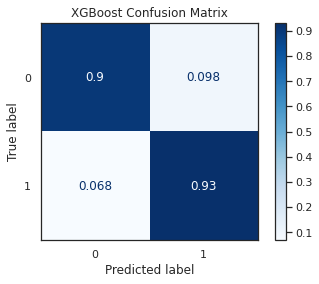

In [49]:
sns.set(style = 'white')
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.title('XGBoost Confusion Matrix')
plt.savefig('figures/confusion_matrix.svg', dpi=300)
plt.show()

In [50]:
print(tuned_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [51]:
xgboost.plot_tree(tuned_model, num_trees = 0, rankdir = 'LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('figures/tree.svg')
plt.close()

In [53]:
fit_var = tuned_model.fit(X_test, y_test)

In [55]:
important_feature = fit_var.feature_importances_
feature_names = X.columns.tolist()
df_feature = pd.DataFrame(data = important_feature, columns = ['values'])
df_feature['feature_names'] = feature_names
df_feature = df_feature.sort_values(by = ['values'], ascending = False)
df_feature.head()

values     feature_names
1  0.440795    offer_duration
0  0.190672       money_spent
6  0.116244    channel_social
3  0.085755  offer_difficulty
2  0.069622      offer_reward

In [56]:
def fix_name(text):
    '''
    Fix name to be plotted

    Params:
        text (str): feature_name
    Returns:
        fixed_text (str): properly formatted text 
    '''
    try:
        temp_text = re.split('_', text)
    except:
        temp_text = text
        
    if len(temp_text) > 1:
        return temp_text[0] + ' ' + temp_text[1]
    else:
        return 'join ' + temp_text[0]

df_feature['display_name'] = df_feature['feature_names'].apply(fix_name)

In [57]:
df_feature['display_name']

1          offer duration
0             money spent
6          channel social
3        offer difficulty
2            offer reward
7             channel web
9               join 2016
4          offer discount
8         days membership
5     offer informational
10              join 2018
Name: display_name, dtype: object

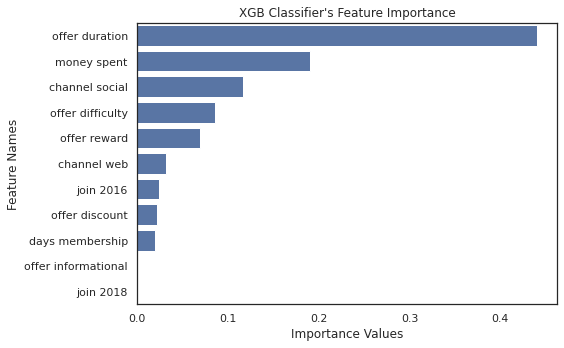

In [58]:
plt.figure(figsize=(8,5))
sns.barplot(data = df_feature, x = 'values', y = 'display_name', color='b')
plt.title('XGB Classifier\'s Feature Importance')
plt.xlabel('Importance Values')
plt.ylabel('Feature Names')
plt.tight_layout()
plt.savefig('figures/XGB_feature_importance.svg', dpi = 300, bbox_inches="tight");
plt.show()

### 4.e. Conclusion

The plot above specifies that the three following features to be the most important:

1. offer_duration
2. money_spent
3. channel_social

Let's take a look at each of these features. Offer duration might be significant since it specifies the number of days the duration of the offer lasts. The longer the offer lasts, the higher the chance for a particular customer to fulfill its requirement. How about money spent? Unlike income, the money spent by a user typically reflects a closer lifestyle of that person. The more often you buy, the higher the chance that you will buy enough to meet the offer conditions. This is more informational than the income information, since it only gives an idea of how much money they make, not how much money they are willing to spend.

Finally, the social channel feature. The fact that this comes in the top three features signifies how social channel is the one that people pay more attention to (obviously does not apply for everyone). This can be used as a reasoning for Starbucks to concentrate more on advertising/sending their offers through these social channels, instead of through web for example. One thing to note though, the email channel is not included in the training data since it contains little to no variation between datasets. Therefore, it might interesting to do a little further experiment to see if whether email is a more effective and efficient method of sending Starbucks offers.

## 5. Discussion and Overall Conclusion

This capstone project concerns with analyzing customers behavior in whether they are likely to respond to an offer as well as finish them, by knowing their demographic information. The aim of this project is to build a machine learning model that would generalize well enough to a model it has not seen before while maintaining high accuracy prediction values. This project is divided into multiple sections:

1. Project Overview
2. Data Analysis
3. Feature Selection and Engineering
4. Model Selection and Tuning

### Project Overview

This section mainly explains what the project is about, certain aspects to look forward to, as well as the expectation of the project. It is also mentioned in this section, that several features such as income, can be the driving factor of Starbucks' customers behavior. The metric used for this analysis is an accuracy rating due to the problem being a binary classification. 

### Data Analysis

The data analysis entails exploring and cleaning the data. Since the desired data needs to be entried of unique customers with their offers labeled with the information of whether they fulfill the offer criteria, each of the .json data is cleaned individually prior to be combined. The combination of these three was proven to be the most challenging and time-consuming due to the nature of how the data set is presented. In the end, an offer is marked completed only if the customer has **seen** the offer, and manage to **complete** the offer within the **time frame**.

### Feature Selection and Engineering

The function to achieve the criterion mentioned before is implemented in this section. Once the data is obtained, a further analysis of the customer behavior based on their demographics is performed. The trend for both male and female is quite similar in the ways they finished the Starbucks offers (based on the offer ids). An interesting find is that Starbucks will have the highest chance of having its customers complete the offers by sending them information through **both web and social**, in addition to email. This is something that can be looked into and tested further for confirmation.

### Model Selection and Tuning

There are five models used to analyze the data (after preprocessing, applying dummies and normalization). The features used as the input for the model are chosen based on their correlation towards the target value (offer_completed column). Out of those five, three are heavily considered:

1. Random Forest
    - Random Forest performs quite well in terms of accuracy, however it suffers from high variance. This means that the model is not performing any better with higher training sizes. Usually this problem can be fixed easily by adding more data entries, yet this capstone project's data entries are fixed in number.
    
    
2. Adaptive Boosting
    - Adaptive boosting is superior in terms of accuracy compared to Random Forest, yet it suffers from high bias. This lets the model to fit poorly towards the data it has not seen. 
    
    
3. XGB Classifier
    - XGB Classifier comes out on top. The training and validation scores converge to a similar value, just right so that this model can generalize well to unseen data. Due to its high accuracy score and the ideal learning curve, XGB Classifier is chosen as the machine learning model for this project.
    
Based on XGB Classifier's features importance, there are three main features that drive this classification model:

1. offer_duration
    - This feature comes first, probably because it describes an appropriate time window for customer to finish their offer (provide just enough frequency for them to purchase Starbucks products).
    
    
2. money_spent
    - Reflects the spending habit of a person, rather than income. Having a high income does not necessarily mean a person is willing to spend money frequently. This is not as the expectation laid down in section 1 where income is thought to be important. 
    
    
3. channel_social
    - The exposure of social channels are probably huge for most of Starbucks' customers.
    
### Conclusion and Improvements

Based on these findings, Starbucks can concentrate on campaigning its variety of offers through social channels while maintaining a moderate offer duration for the customers. Trying to find a customer with higher money spent within certain time frames might be beneficial rather than keeping track of their yearly income. As for gender, it does not seem that there should be any preferences for Starbucks to target, as long as these offers are sent based on the parameters discussed. 

There are several improvements that can be implemented:

1. Perform a thorough experiment:
    - This can be performed using A/B Testing where one group consists of people who are exposed to the offers only from web while the other is from social channels.
    - Another experiment that concentrates on determining what offer duration to be best for these customers so that Starbucks can design an offer that would specifically target this behavior. 
  
  
2. A better model tuning:
    - Due to limitation of computing power (running on local machine), only several parameters of XGB Classifier were successfully tuned. Therefore this model can definitely be improved to a higher accuracy (hopefully 95%+). 
    
    
3. A better step or method in combining the data sets:
    - Definitely the main bottleneck of the project, since this process takes a long time to run. It might be beneficial to perform this process using a different method rather than implementing a nested loop. 